# RICH AI Exploratory Data Analysis - Rings

Notes
- Labels are 0: Muon, 1: Pion, 2: Positron
- Likelihood labels are different [Pion, Muon, Positron]

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

# Helper functions

In [2]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [3]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas"""
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    
    # TODO: check w/ TRIUMF if this is correct
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    return df

In [4]:
def compute_seq_id(disk_id, up_dw_id, sc_id, pm_id, or_id=0):
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return seq_id

In [5]:
def event_info(dfile):
    """Retreive """
    #getting event data, hit data and hit mapping from the data file
    events=dfile['Events']
    hits=dfile['Hits']
    hit_map=dfile['HitMapping']
    
    #chod time array
    chod_times=events['chod_time']
    
    #momentum array
    momentum=events['track_momentum']
    
    #positioning mapping that corresonds to the position of each sensor 
    position_map = np.load("/home/mukund/RICHPID/event_display/rich_pmt_positions.npy")
    
    return events, hits, hit_map, chod_times, momentum, position_map

In [86]:
def momentum_bin_hits(dfile, particle_offset, sample_size, momentum_lwr, momentum_upr, delta_time):
    """ Create an array of hits and event information in a specific momentum bin
    
    Parameters
    ----------
    dfile : dict
        Dictionary of HFD data sets
    
    particle_offset: int
        Starting index of particle data in events array 
    
    sample_size: int
        Number of events to be surveyed for each particle
        
    momentum_lwr : flt
        The lower bound of the momentum bin
    
    momentum_upr : flt
        The upper bound of the momentum bin
    """
    
    events, hits, hit_map, chod_times, momentum, position_map=event_info(dfile)
    
    particle_hits=[]
    ring_radius=[]
    ring_centre=[]
    momentum_arr=[]
    event_num=[]

    for event in range(particle_offset, particle_offset + sample_size):

        hits_xy=[]
        if momentum[event]>momentum_lwr and momentum[event]<momentum_upr:

            chod_time=chod_times[event]
            hits_event=hits[hit_map[event]:hit_map[event+1]]
            hit_times=hits_event['hit_time']
            delta=hit_times-chod_time
            not_noise=np.absolute(delta<delta_time)
                
                
            #retrieving the ring radius and momentum for the event
            ring_radius.append(events['ring_radius'][event])
            ring_centre.append(events['ring_centre_pos'][event])
            momentum_arr.append(momentum[event])
            event_num.append(events['event_id'][event])

            for pm_info in hits_event:
                pm_idx = (
                    compute_seq_id(
                    disk_id=pm_info["disk_id"],
                    up_dw_id=pm_info["updowndisk_id"],
                    sc_id=pm_info["supercell_id"],
                    pm_id=pm_info["pmt_id"]
                    )
                )

                hits_xy.append(position_map[pm_idx][0:2])

            hits_xy = np.array(hits_xy)
            particle_hits.append(np.c_[hits_xy, hit_times, hit_times-chod_time, not_noise])

    particle_hits=np.array(particle_hits, dtype=object)
    particle_event=np.c_[np.array(ring_centre), np.array(ring_radius), momentum_arr, event_num]
        
    return particle_hits, particle_event

In [87]:
file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
data_files = read_RICHAI_data(file_paths)
dfile=data_files['A/Run008563']

In [85]:
particle_offset=0
sample_size=20
momentum_lwr=20
momentum_upr=25
delta_time=5

events, hits, hit_map, chod_times, momentum, position_map=event_info(dfile)

particle_hits=[]
ring_radius=[]
ring_centre=[]
momentum_arr=[]
event_num=[]

for event in range(particle_offset, particle_offset + sample_size):
    hits_xy=[]
    if momentum[event]>momentum_lwr and momentum[event]<momentum_upr:

        chod_time=chod_times[event]
        hits_event=hits[hit_map[event]:hit_map[event+1]]
        hit_times=hits_event['hit_time']
        delta=hit_times-chod_time
        not_noise=np.absolute(delta<delta_time)
                
                
        #retrieving the ring radius and momentum for the event
        ring_radius.append(events['ring_radius'][event])
        ring_centre.append(events['ring_centre_pos'][event])
        momentum_arr.append(momentum[event])
        event_num.append(events['event_id'][event])

        for pm_info in hits_event:
            pm_idx = (
                    compute_seq_id(
                    disk_id=pm_info["disk_id"],
                    up_dw_id=pm_info["updowndisk_id"],
                    sc_id=pm_info["supercell_id"],
                    pm_id=pm_info["pmt_id"]
                    )
                )

            hits_xy.append(position_map[pm_idx][0:2])
                
        hits_xy=np.array(hits_xy)
        particle_hits.append(np.c_[hits_xy, hit_times, hit_times-chod_time, not_noise])
        particle_hits=np.array(particle_hits)
        particle_event=np.c_[np.array(ring_centre), np.array(ring_radius), momentum_arr, event_num]

In [92]:
def hit_data_array(dfile, sample_size, momentum_lwr, momentum_upr, delta_time, muon_array=True, pion_array=True, positron_array=True):
    """Create arrays for hits each particle for a given momentum range
    
    Parameters
    ----------
    dfile : dict
        Dictionary of HFD data sets
    
    sample_size: int
        Number of events to be surveyed for each particle
        
    momentum_lwr : flt
        The lower bound of the momentum bin
    
    momentum_upr : flt
        The upper bound of the momentum bin
    
    delta_time : flt
        The 
    
    muon_array : bool
        If muon data needs to be returned
    
    pion_array : bool
        If pion data needs to be returned

    positron_array : bool
        If positron data needs to be returned
        
    Returns
    -------
    muon_hits : numpy array
        Array with hits and event information for muons in momentum range
    
    pion_hits : numpy array
        Array with hits and event information for pions in momentum range
    
    positron_hits : numpy array
        Array with hits and event information for positrons in momentum range
    """
    
    #getting event data, hit data and hit mapping from the data file
    events, hits, hit_map, chod_times, momentum, position_map=event_info(dfile) 
    
    if muon_array==True:
        muon_offset=dfile.attrs["muon_offset"]
        muon_hits, muon_hit_event=momentum_bin_hits(dfile, muon_offset, sample_size, momentum_lwr, momentum_upr, delta_time)
        
    if pion_array==True:
        pion_offset=dfile.attrs["pion_offset"]
        pion_hits, pion_hit_event=momentum_bin_hits(dfile, pion_offset, sample_size, momentum_lwr, momentum_upr, delta_time)
        
    if positron_array==True:
        positron_offset=dfile.attrs["positron_offset"]
        positron_hits, positron_hit_event=momentum_bin_hits(dfile, positron_offset, sample_size, momentum_lwr, momentum_upr, delta_time)
       
    return muon_hits, muon_hit_event, pion_hits,pion_hit_event, positron_hits,  positron_hit_event

In [118]:
muon, muon_event, pion, pion_event, positron, positron_event=hit_data_array(dfile, 20, 20, 35, 5)

In [89]:
# plotting function from Bob that plots the PMT array
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [122]:
def plot_hits(hits, hit_events, particle_label, col_num):
    
    """
        Plot hits for each event for a particle hit array
    """
    events=len(hits)

    rows, _=np.divmod(events,col_num)
    rem=(rows+1)*col_num - events

    fig, ax = plt.subplots(ncols=col_num, nrows=rows+1, figsize=(col_num*7, 8*(rows+1)))
    ax=ax.flatten()

    for i in range(-rem, 0):
        
        fig.delaxes(ax[i])

    for event in range(0, events):
        
        if particle_label==0:
            clr="red"
            label="Muon"
        elif particle_label==1:
            clr="blue"
            label="Pion"
        else:
            clr="green"
            label="Positron"

        ax[event].set_aspect('equal')
        ax[event].set_xlim(-350,350) # mm
        ax[event].set_ylim(-350,350) # mm
        ax[event].set_xlabel('X (mm)')
        ax[event].set_ylabel('Y (mm)')
        
        position_map = np.load("/home/mukund/RICHPID/event_display/rich_pmt_positions.npy")

        #draw_pmt_pos(ax[event], position_map)

        scatter=ax[event].scatter(hits[event][:, 0], hits[event][:, 1], c=hits[event][:,4])

        legend=ax[event].legend(*scatter.legend_elements())
        ax[event].add_artist(plt.Circle((hit_events[event][0], hit_events[event][1]), hit_events[event][2], fill=False,color=clr))

        ax[event].set_title(f'Dataset A \n Event {hit_events[event][4]} \n Label: {label} \n Momentum: {hit_events[event][3]:.2f} \n Ring Radius: {hit_events[event][2]:.2f}')
        ;

# Plots

### Hit data 

<Figure size 2016x576 with 0 Axes>

<Figure size 2016x576 with 0 Axes>

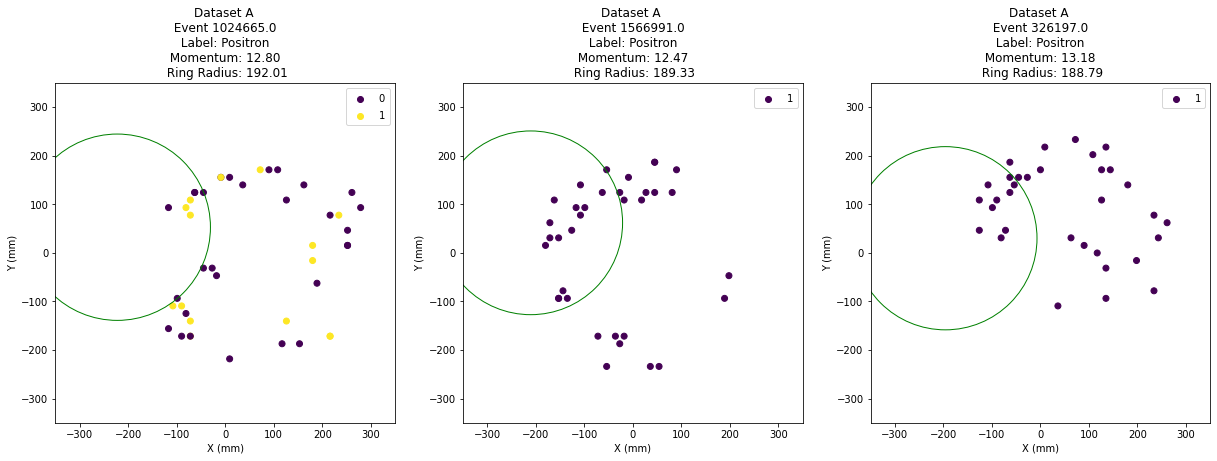

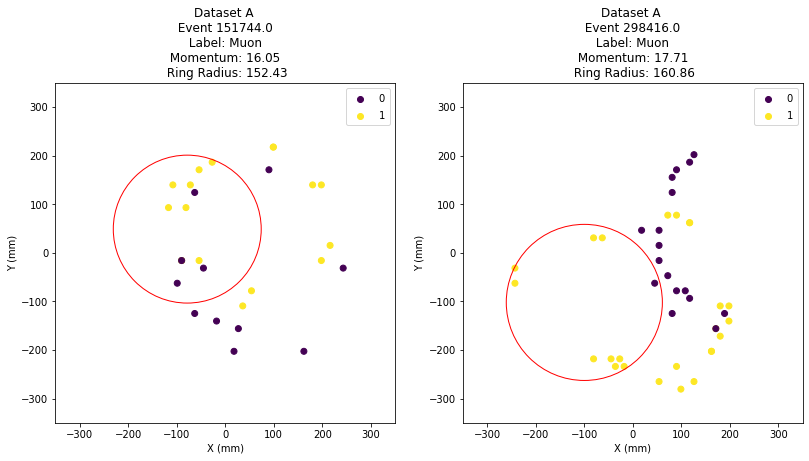

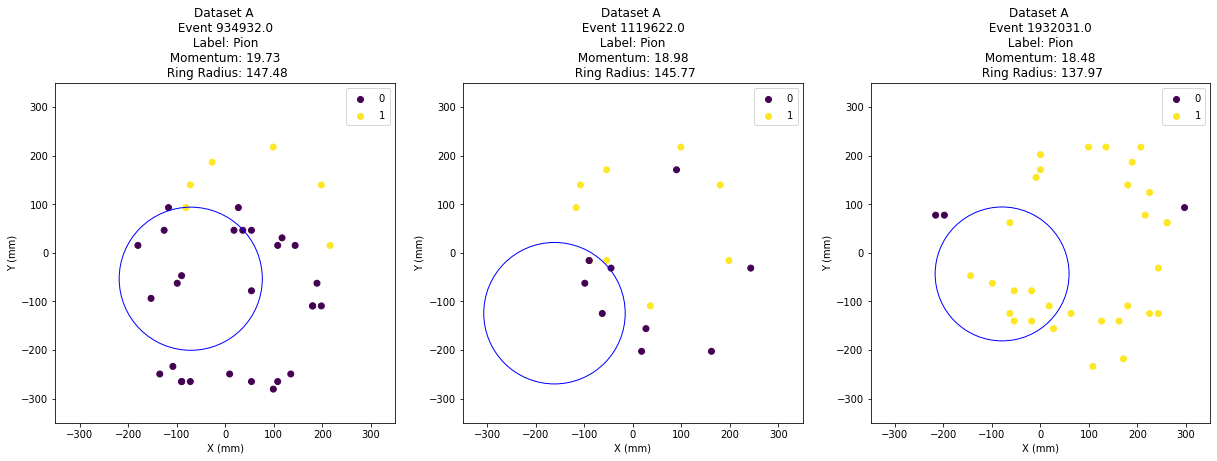

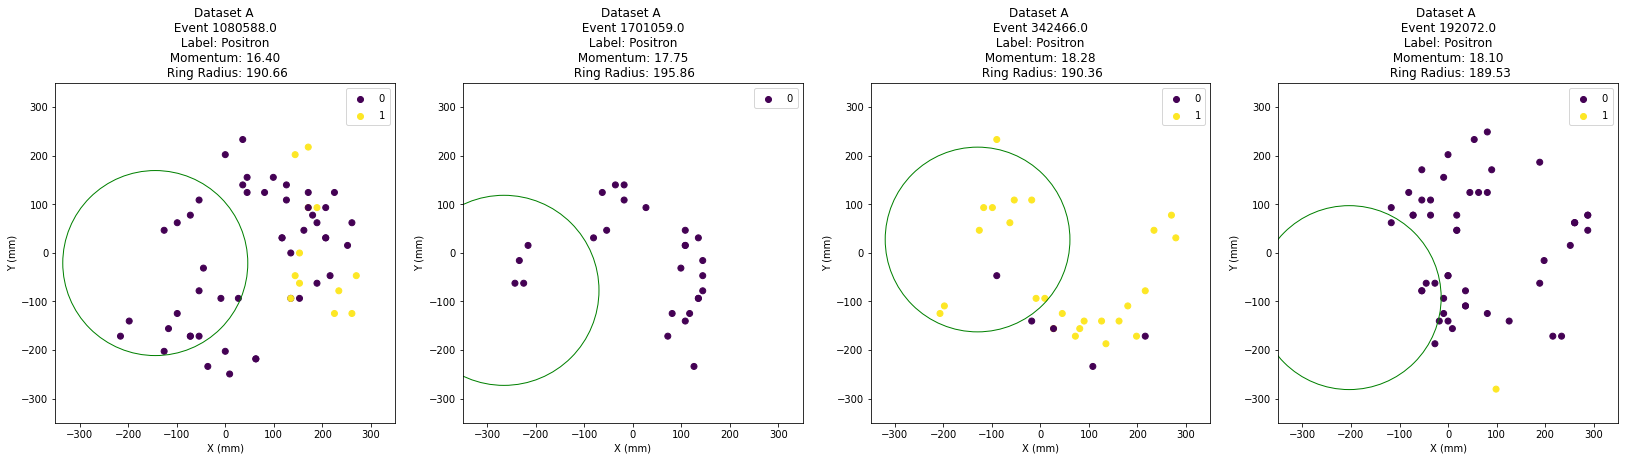

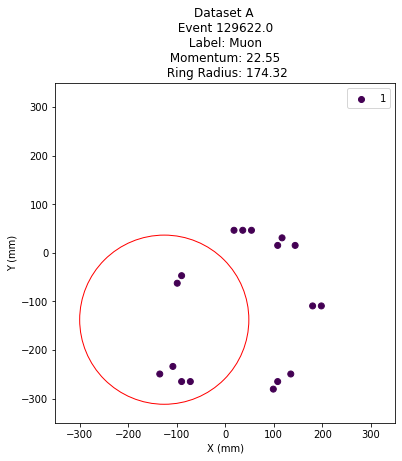

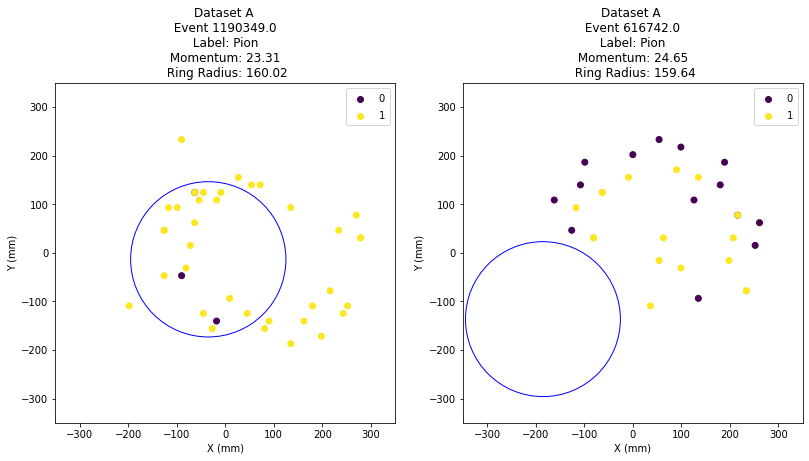

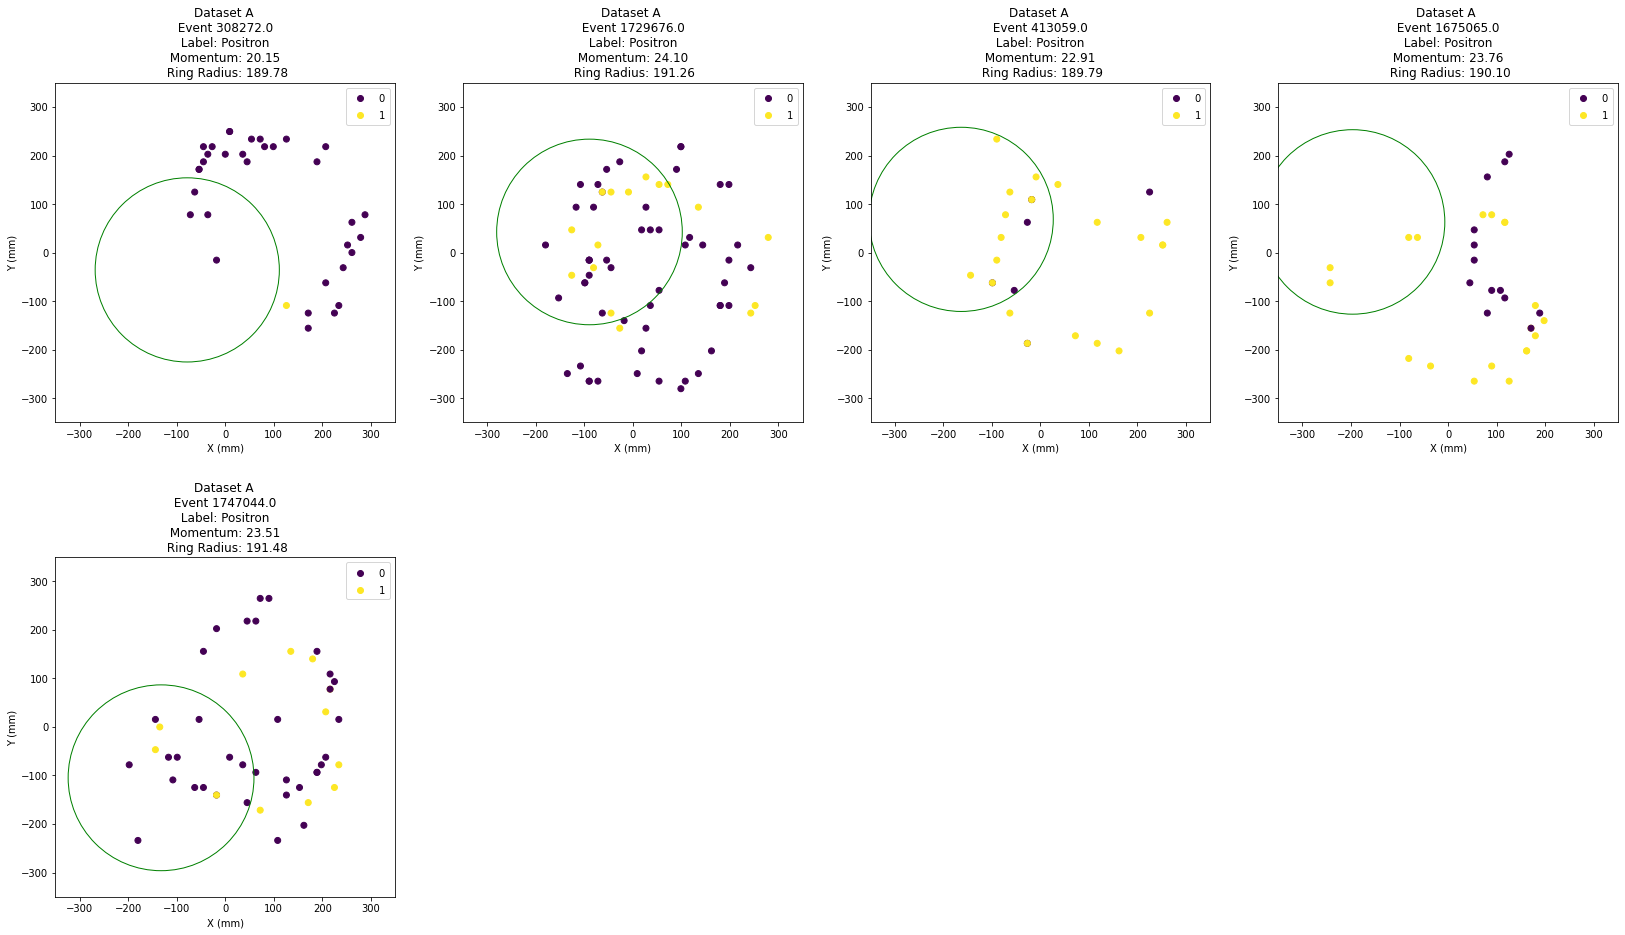

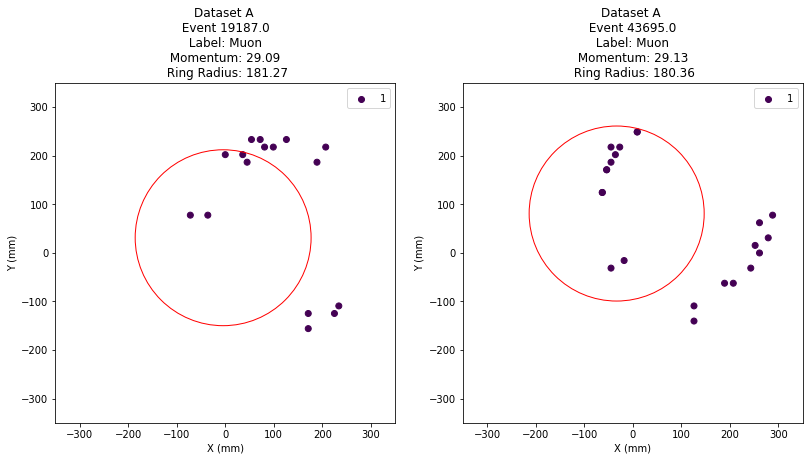

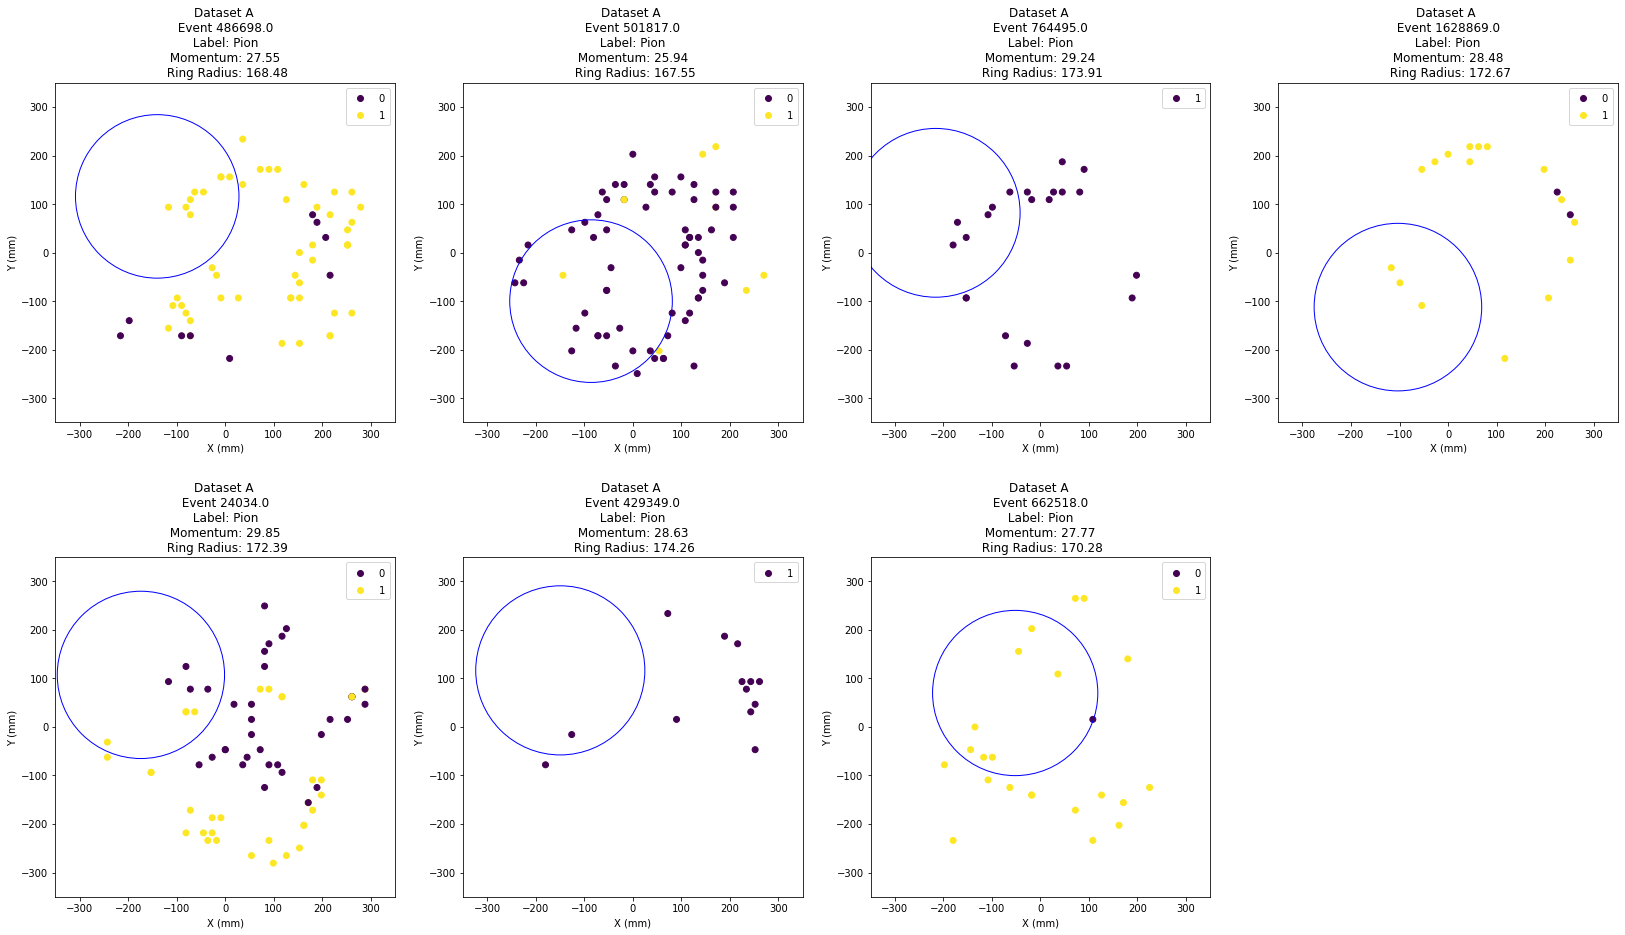

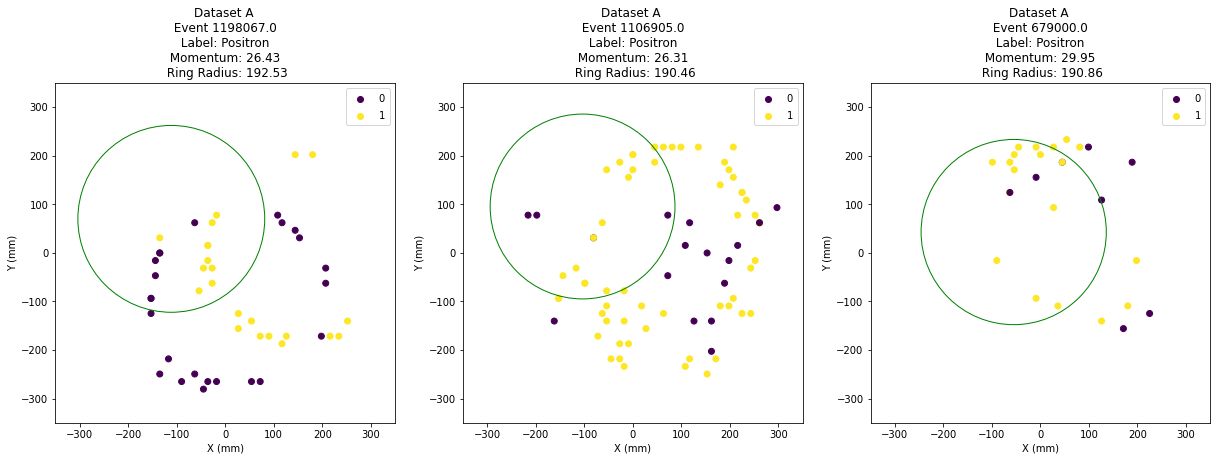

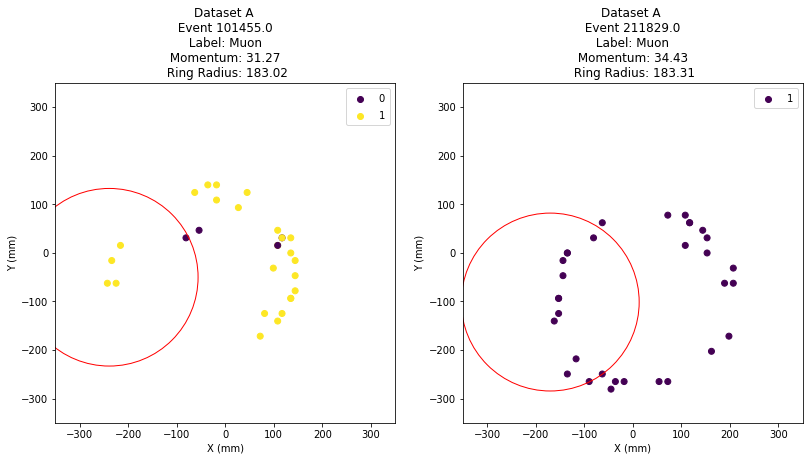

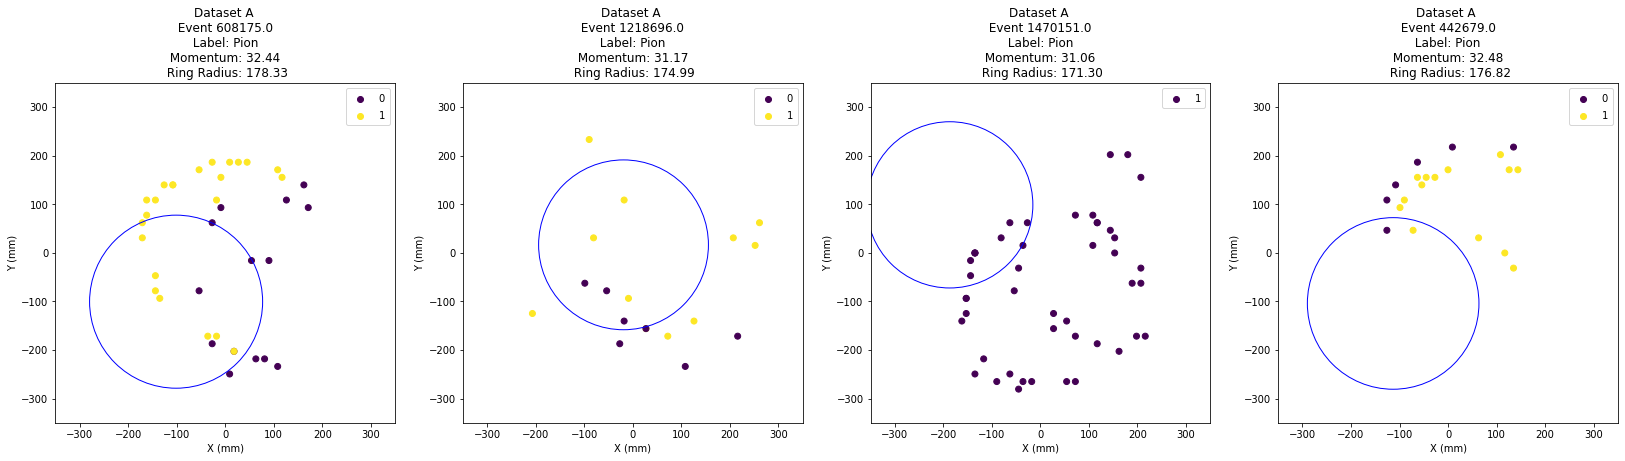

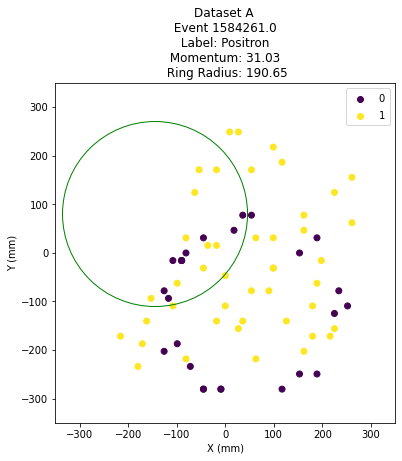

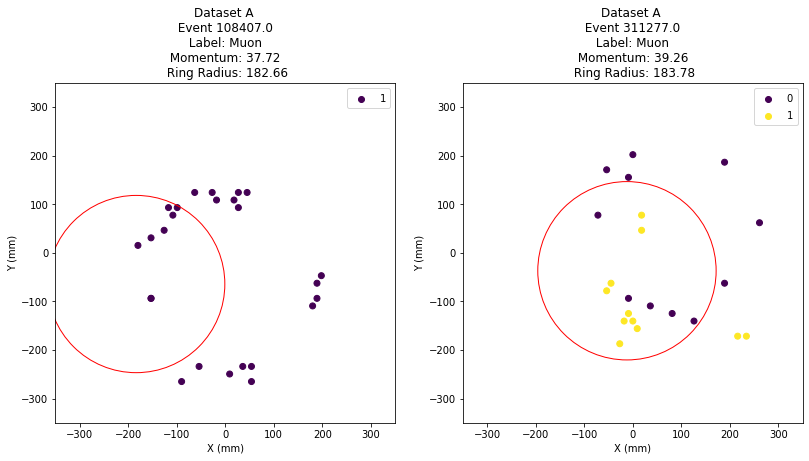

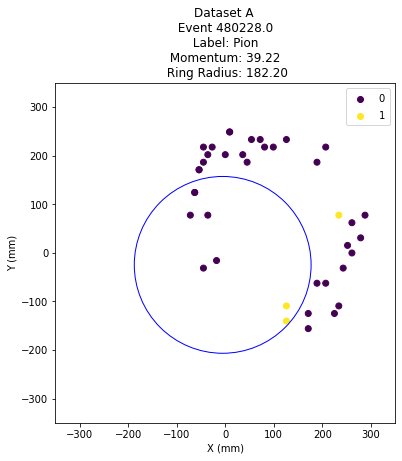

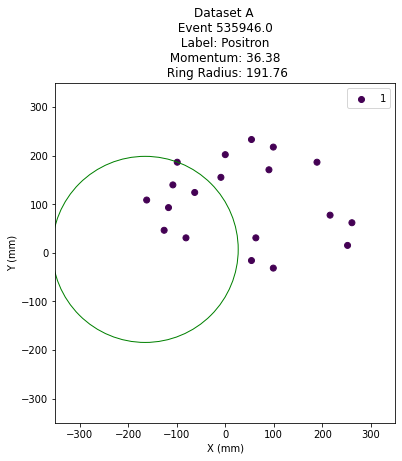

In [124]:
dfile=data_files['A/Run008563']

bins=[(10,15), (15,20) ,(20,25), (25,30),(30,35), (35,40)]
for bin_ in bins:   
    muon, muon_events, pion, pion_events, positron, positron_events=hit_data_array(dfile, 20, bin_[0], bin_[1], 5)
    plot_hits(muon, muon_events, 0, 4)
    plot_hits(pion, pion_events, 1, 4)
    plot_hits(positron, positron_events, 2, 4)

# Ring radius by momentum 

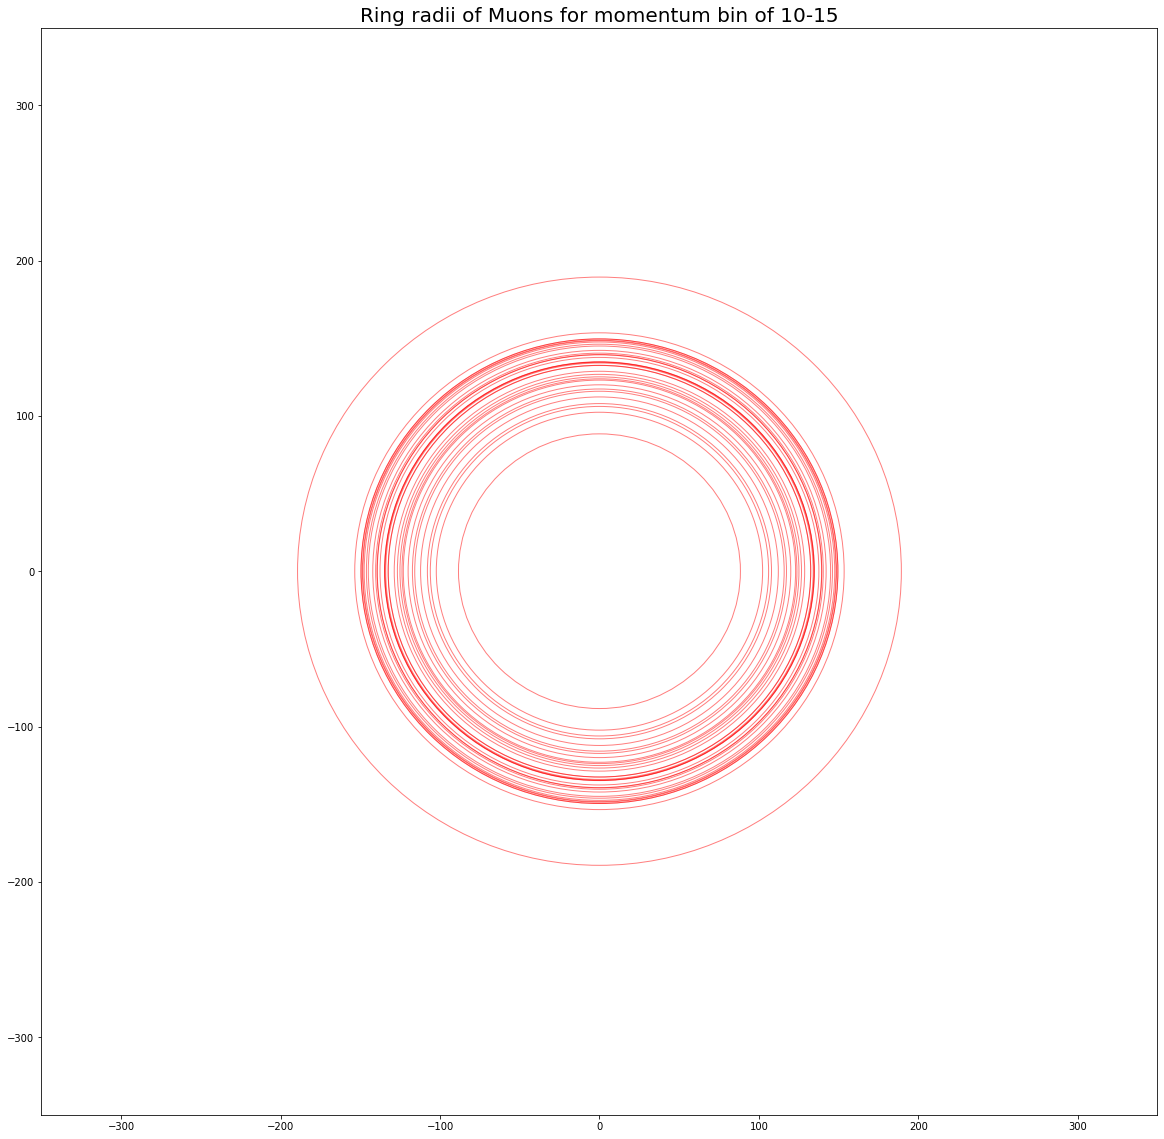

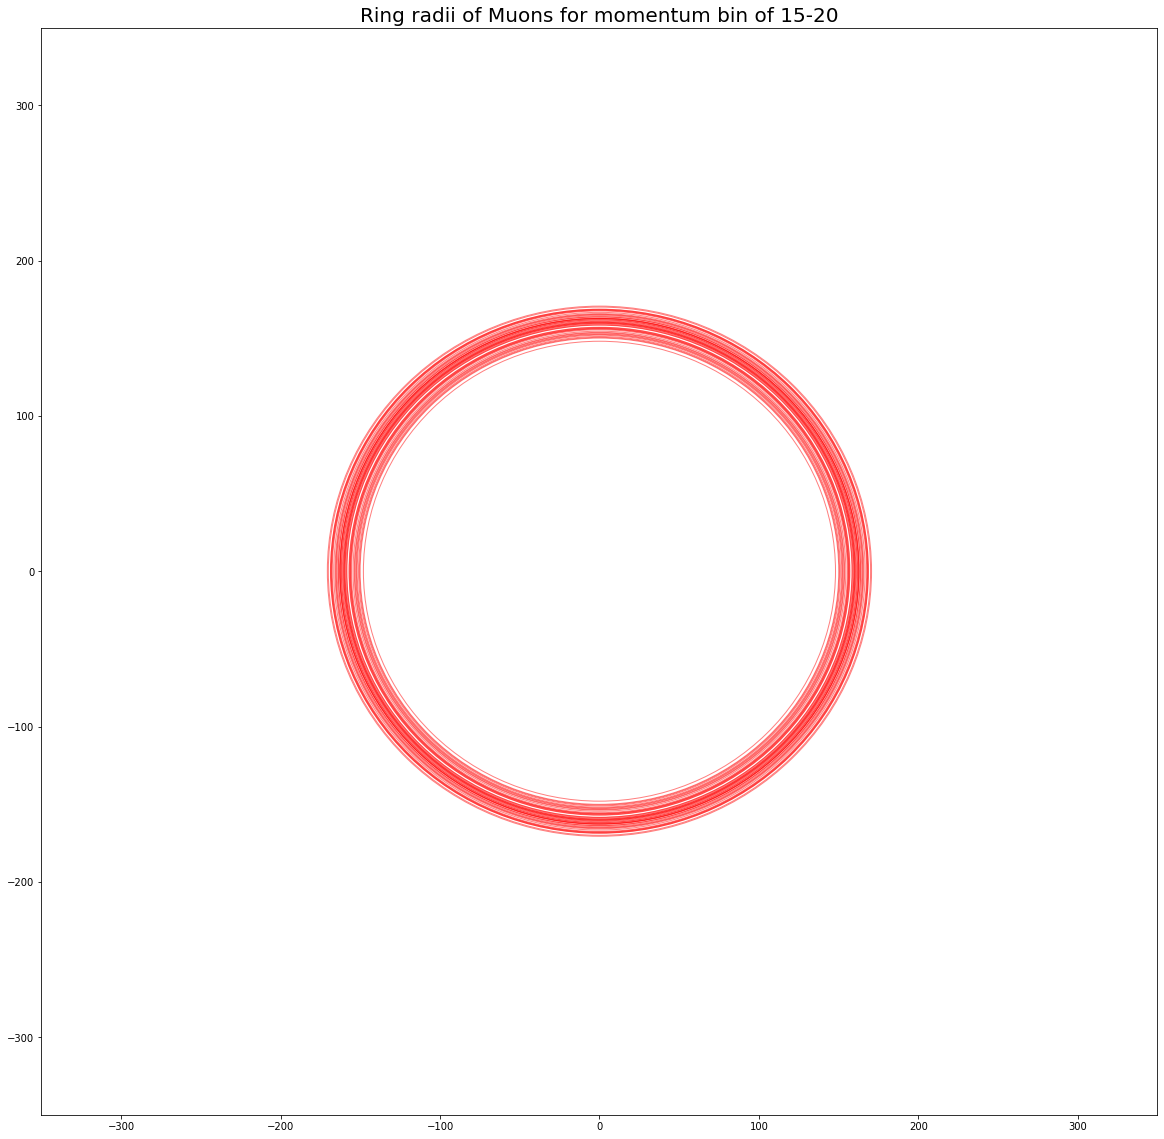

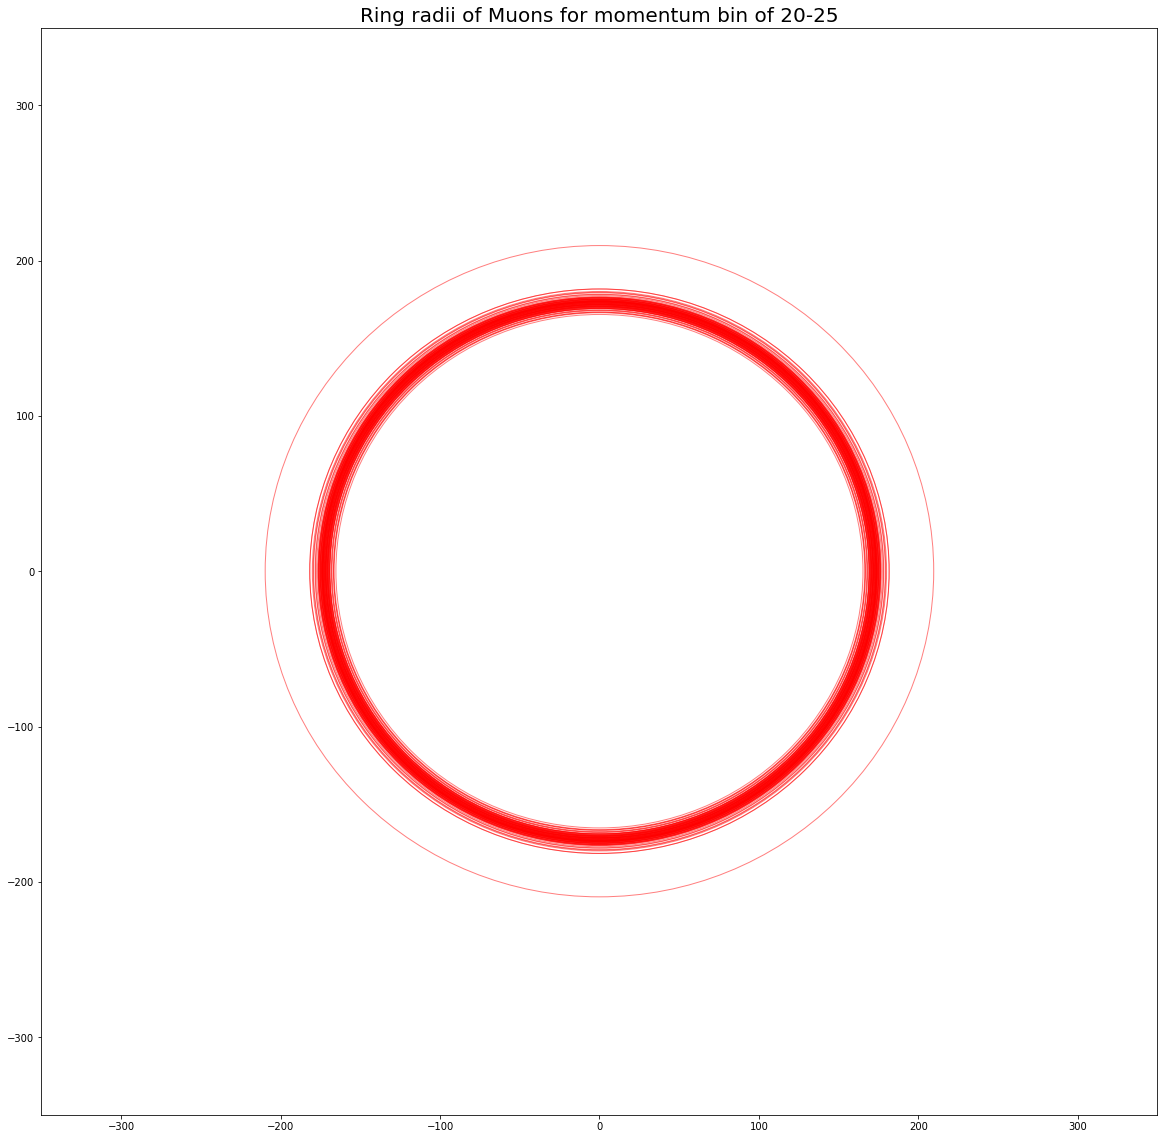

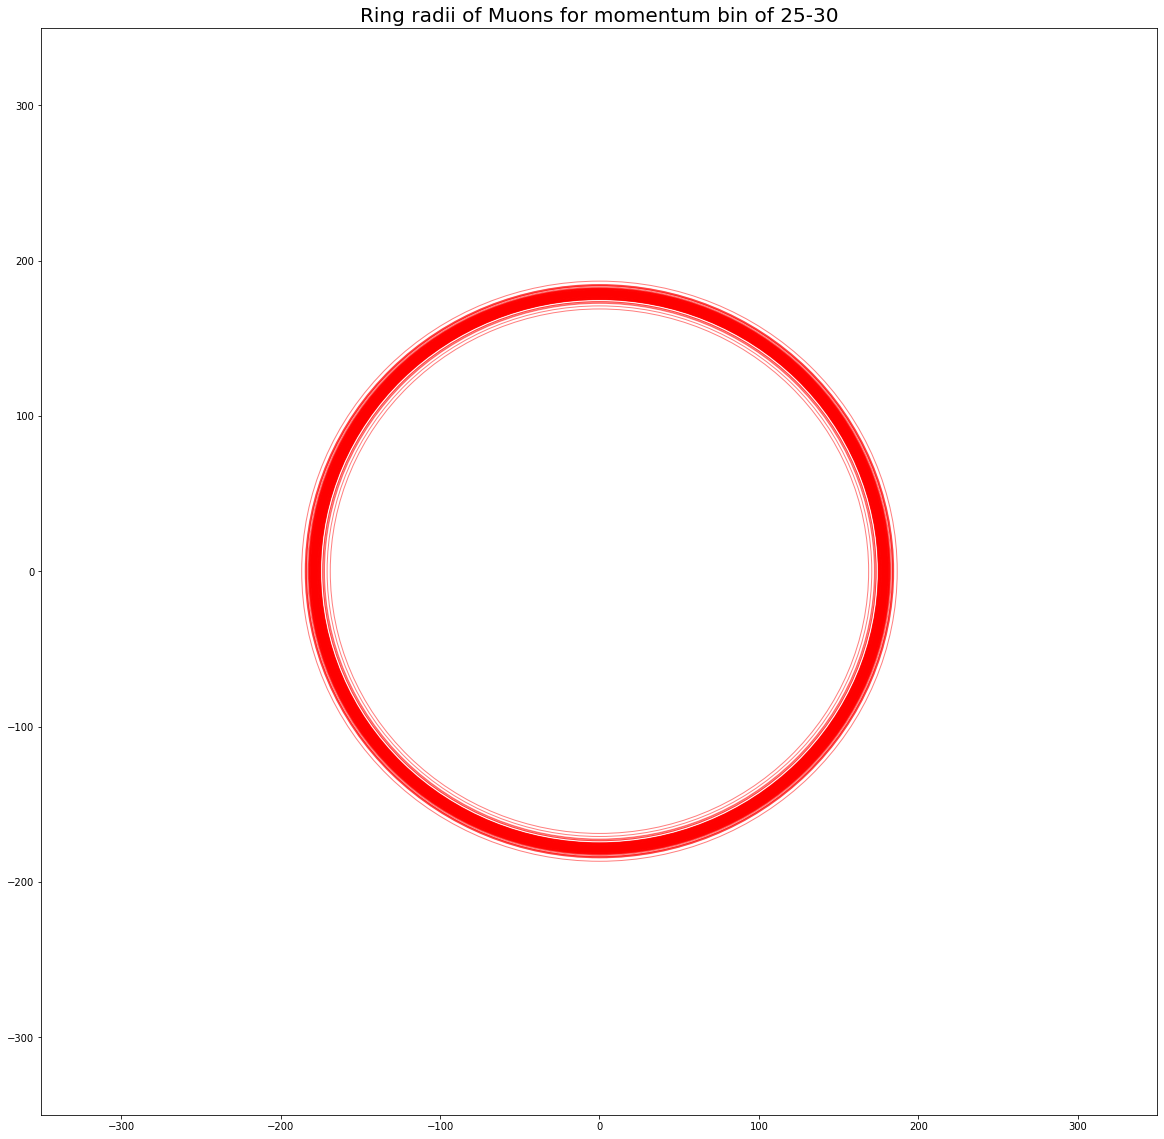

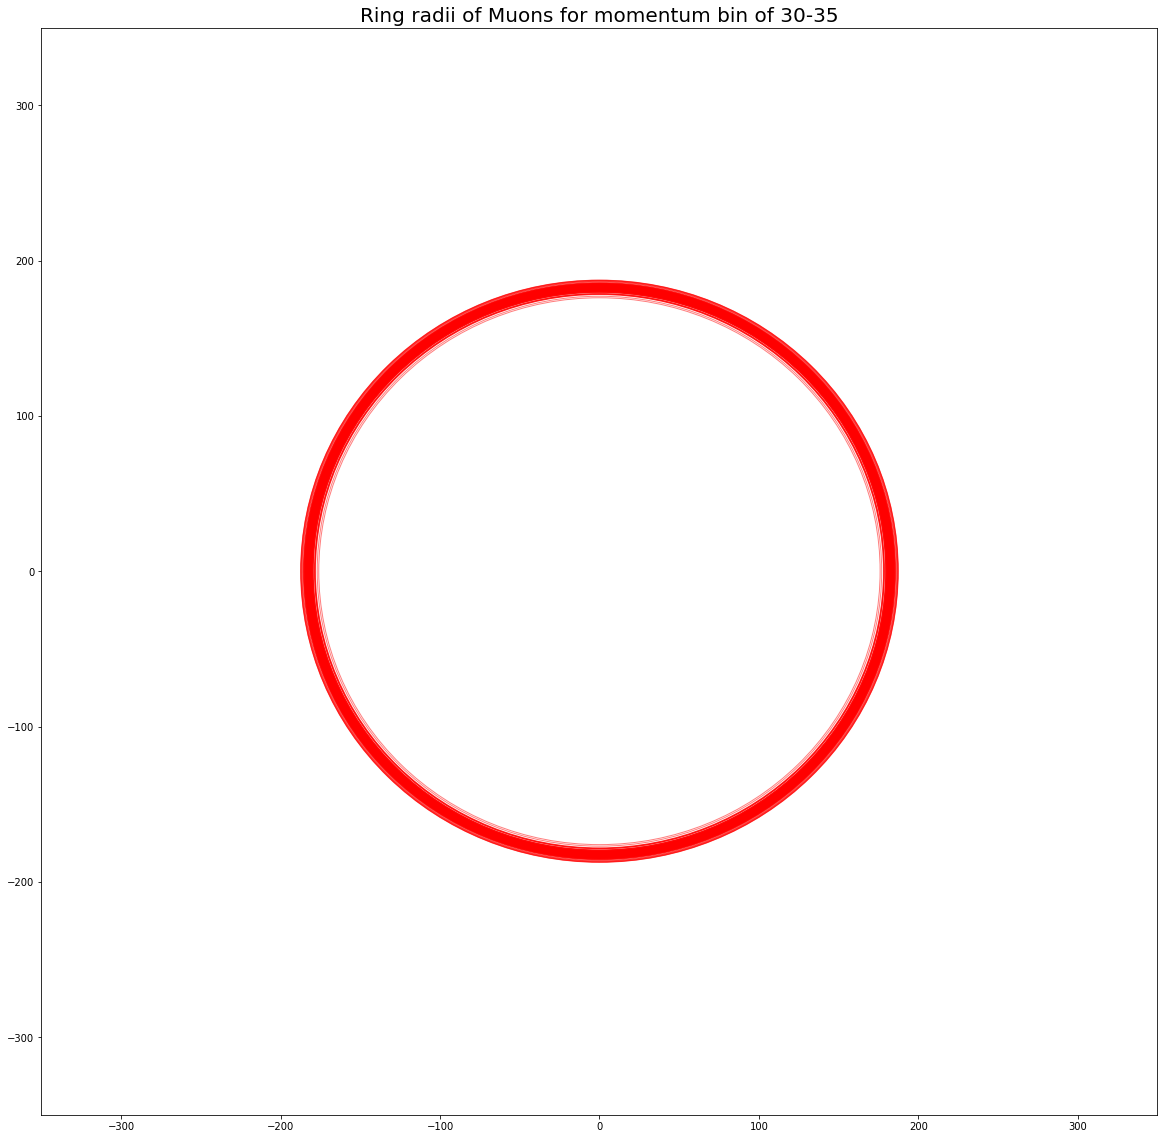

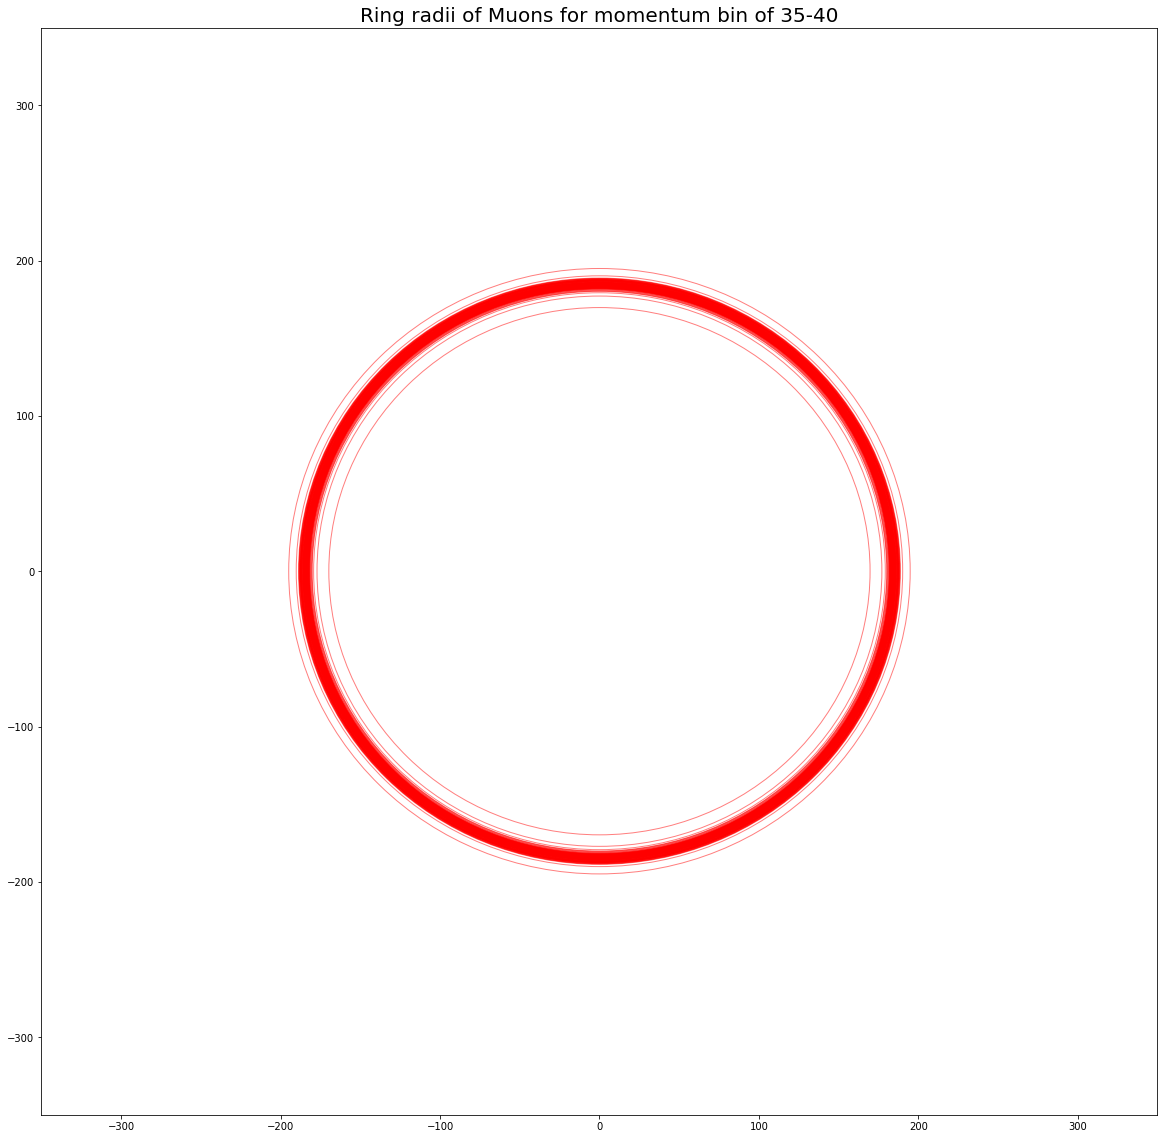

In [139]:
bins=[(10,15),(15,20),(20,25),(25,30),(30,35), (35,40)]

for bin_ in bins:

    muon, muon_event, pion, pion_event, positron, positron_event=hit_data_array(dfile, 1000, bin_[0], bin_[1], 1)
    fig,ax=plt.subplots(figsize=(20,20))
    plt.title(f"Ring radii of Muons for momentum bin of {bin_[0]}-{bin_[1]}", fontsize=20)
    ax.set_xlim(-350,350) # mm
    ax.set_ylim(-350,350) # mm

    for event in range(0,len(muon)):
        ax.add_artist(plt.Circle((0, 0), muon_event[event][2], fill=False, color='red', alpha=0.5))


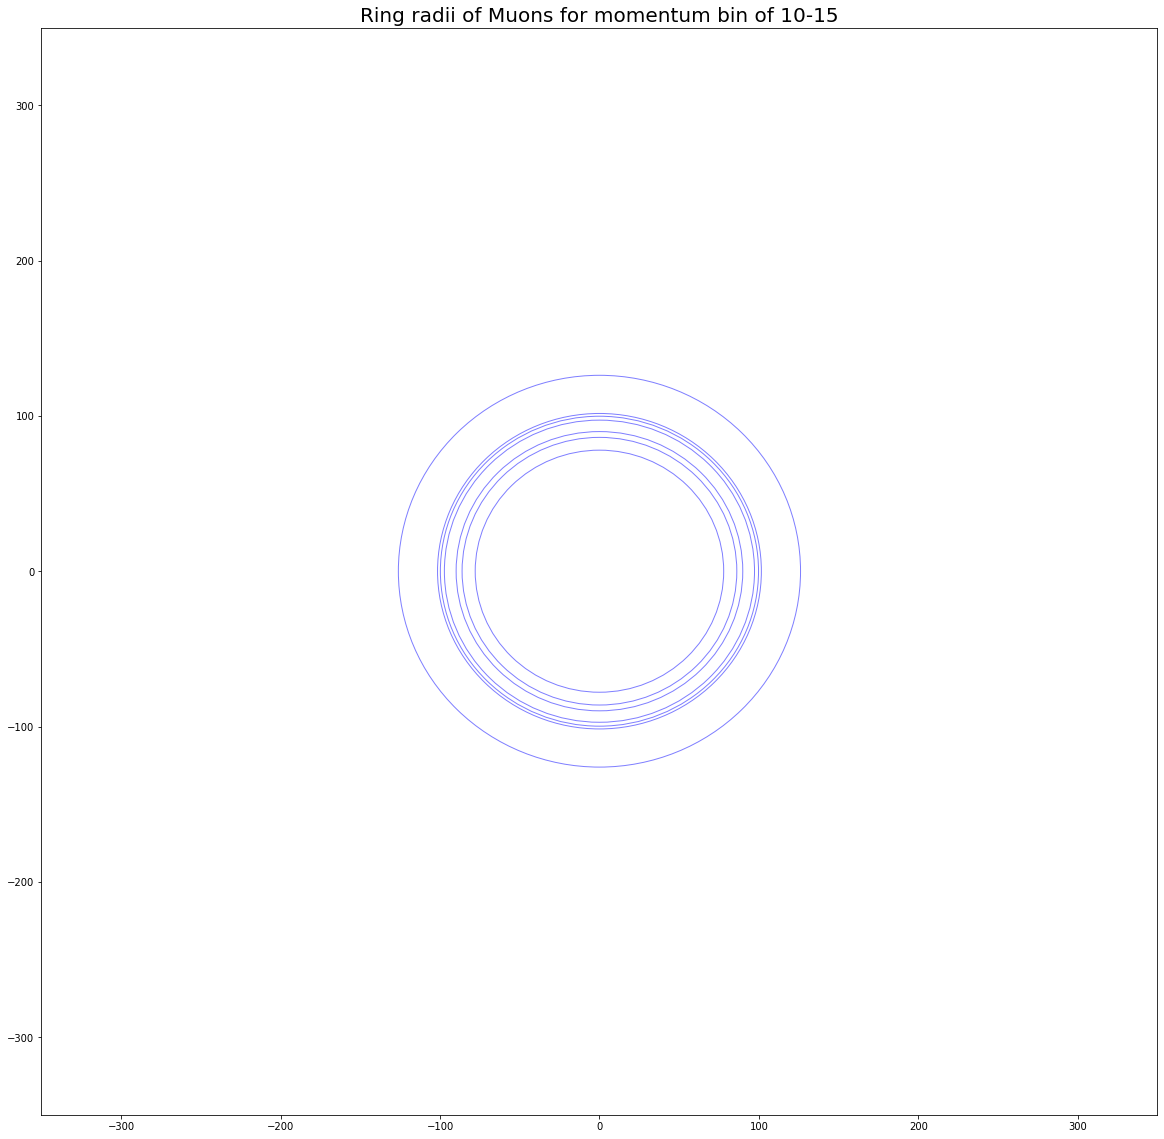

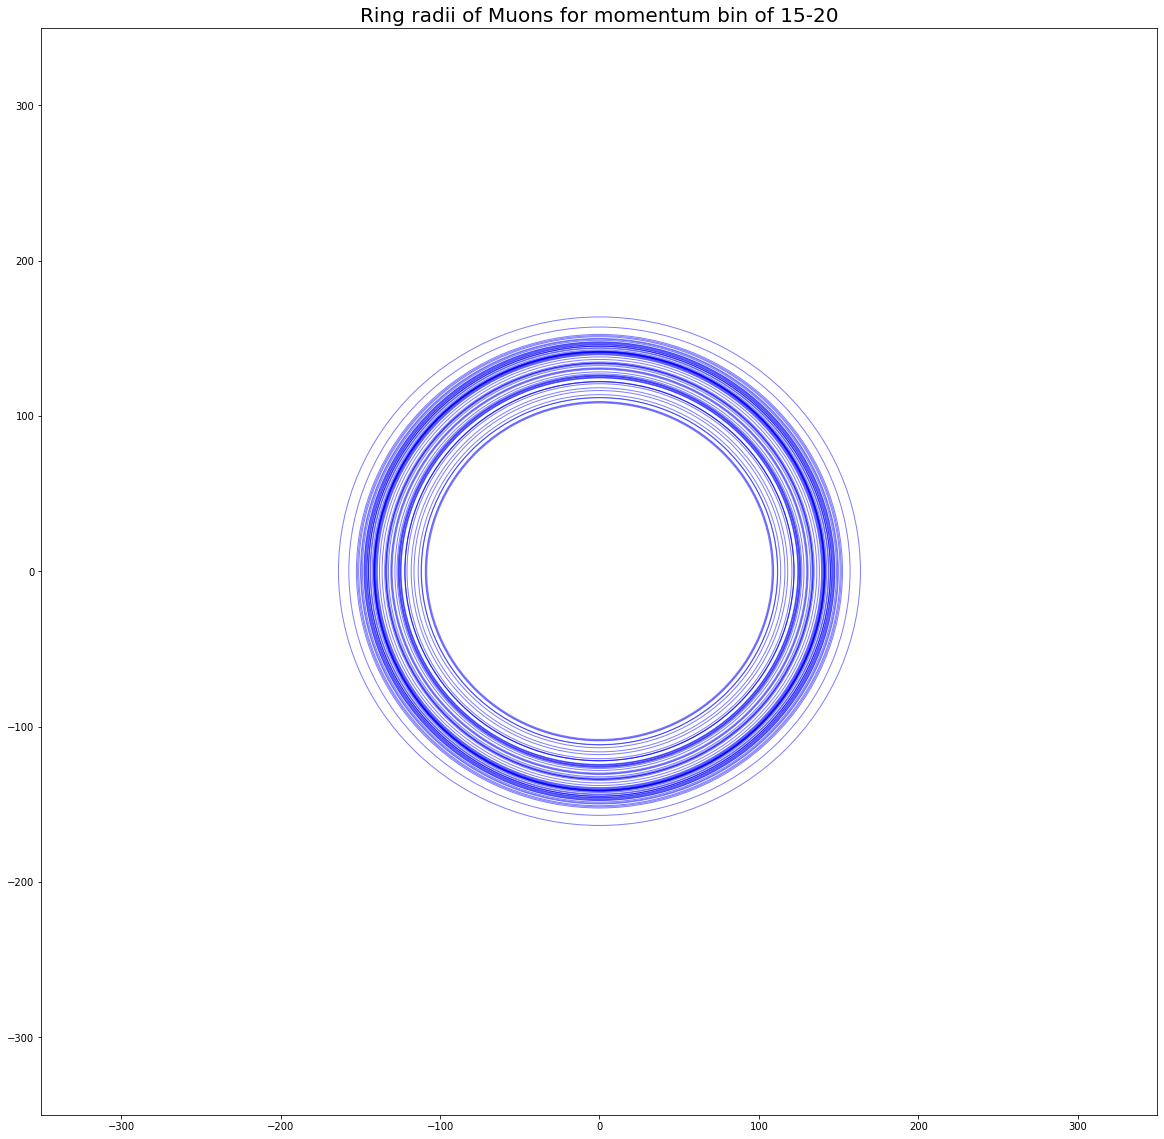

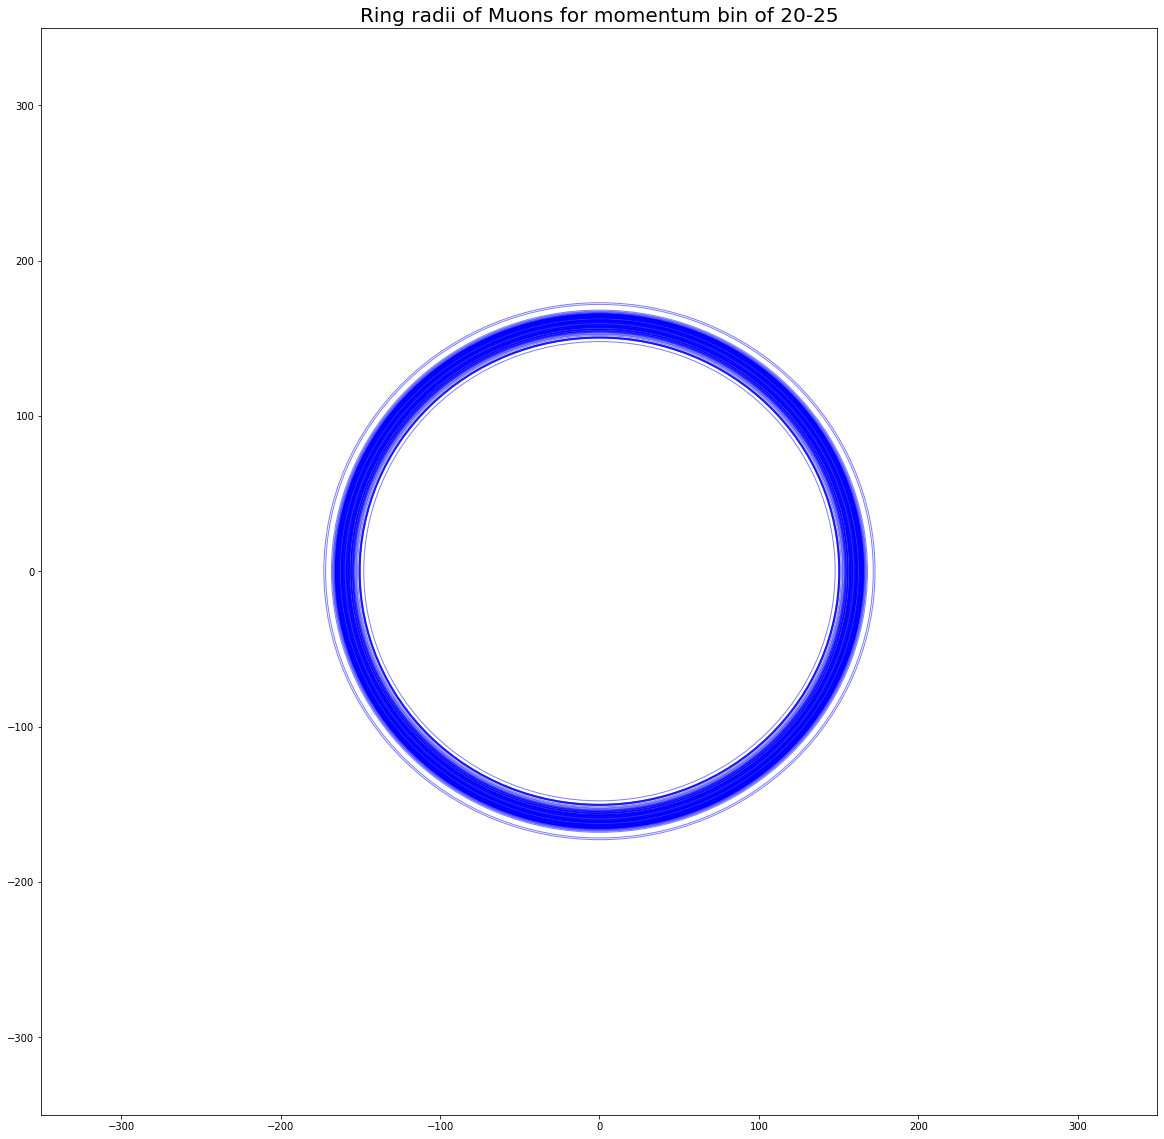

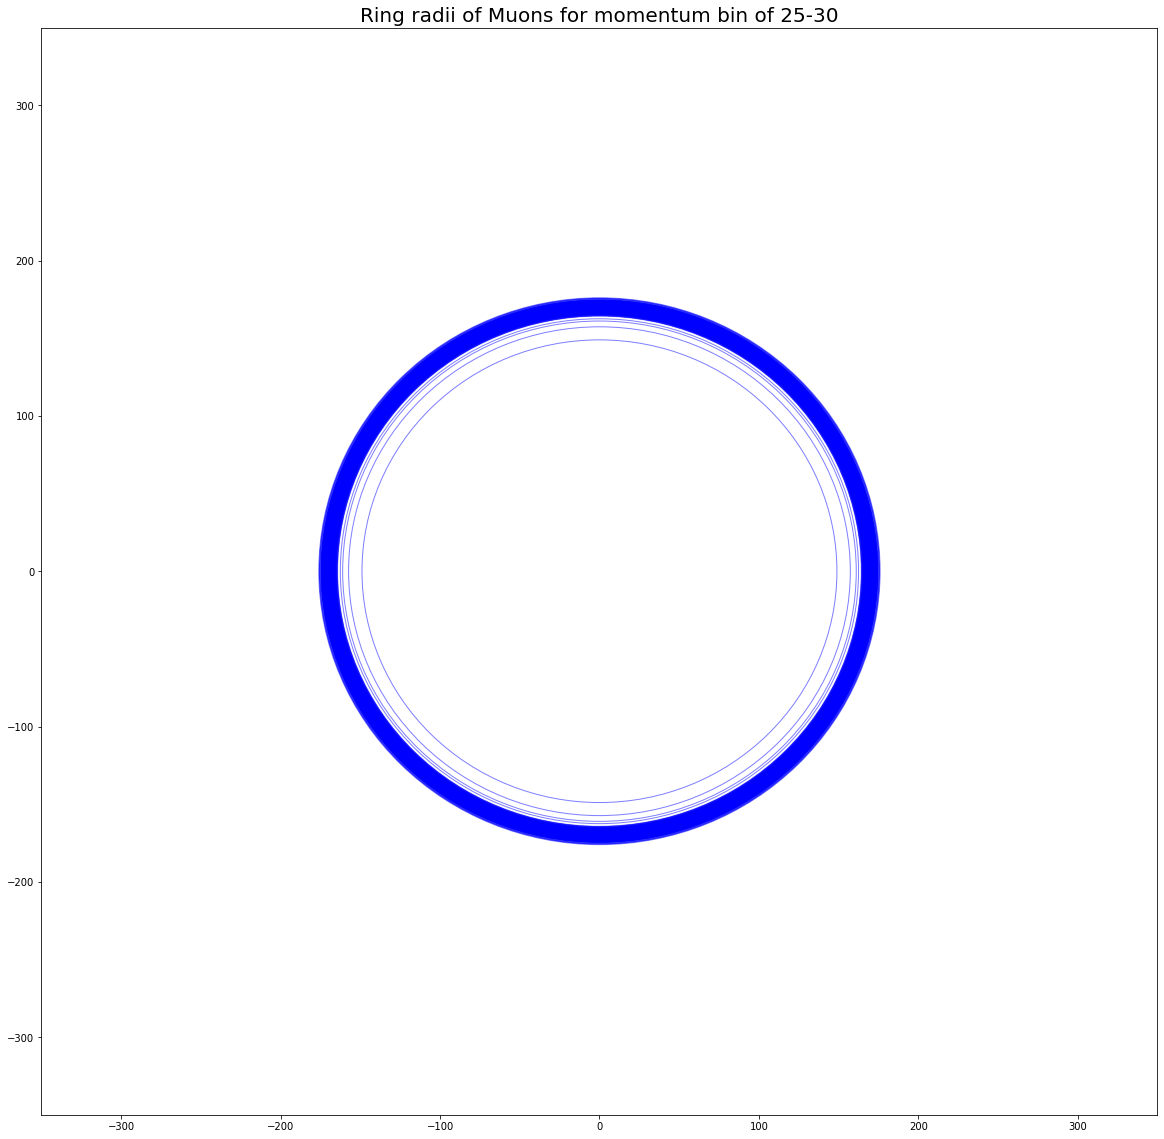

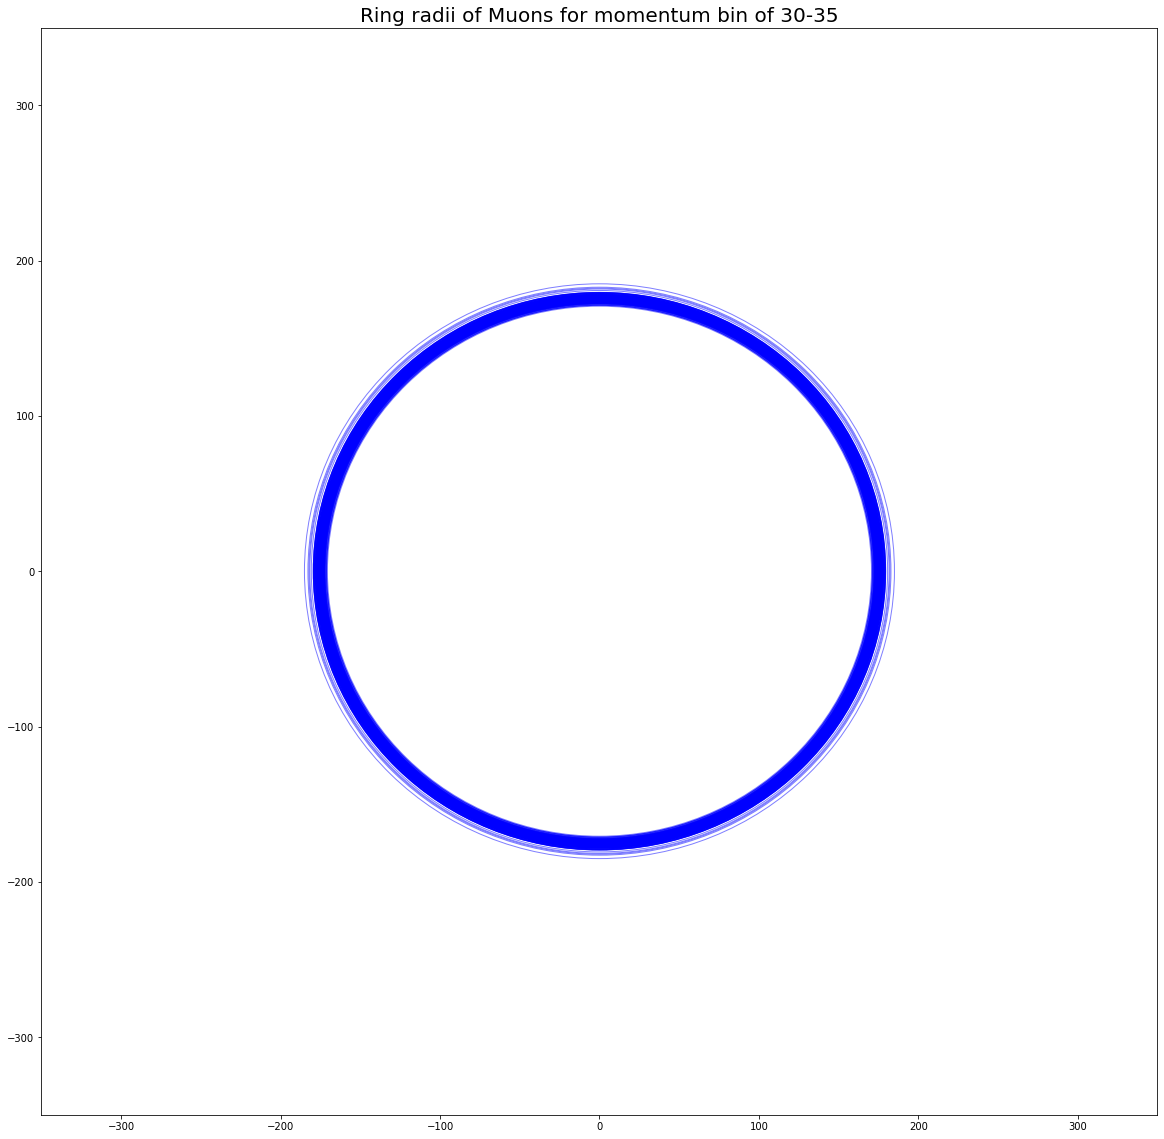

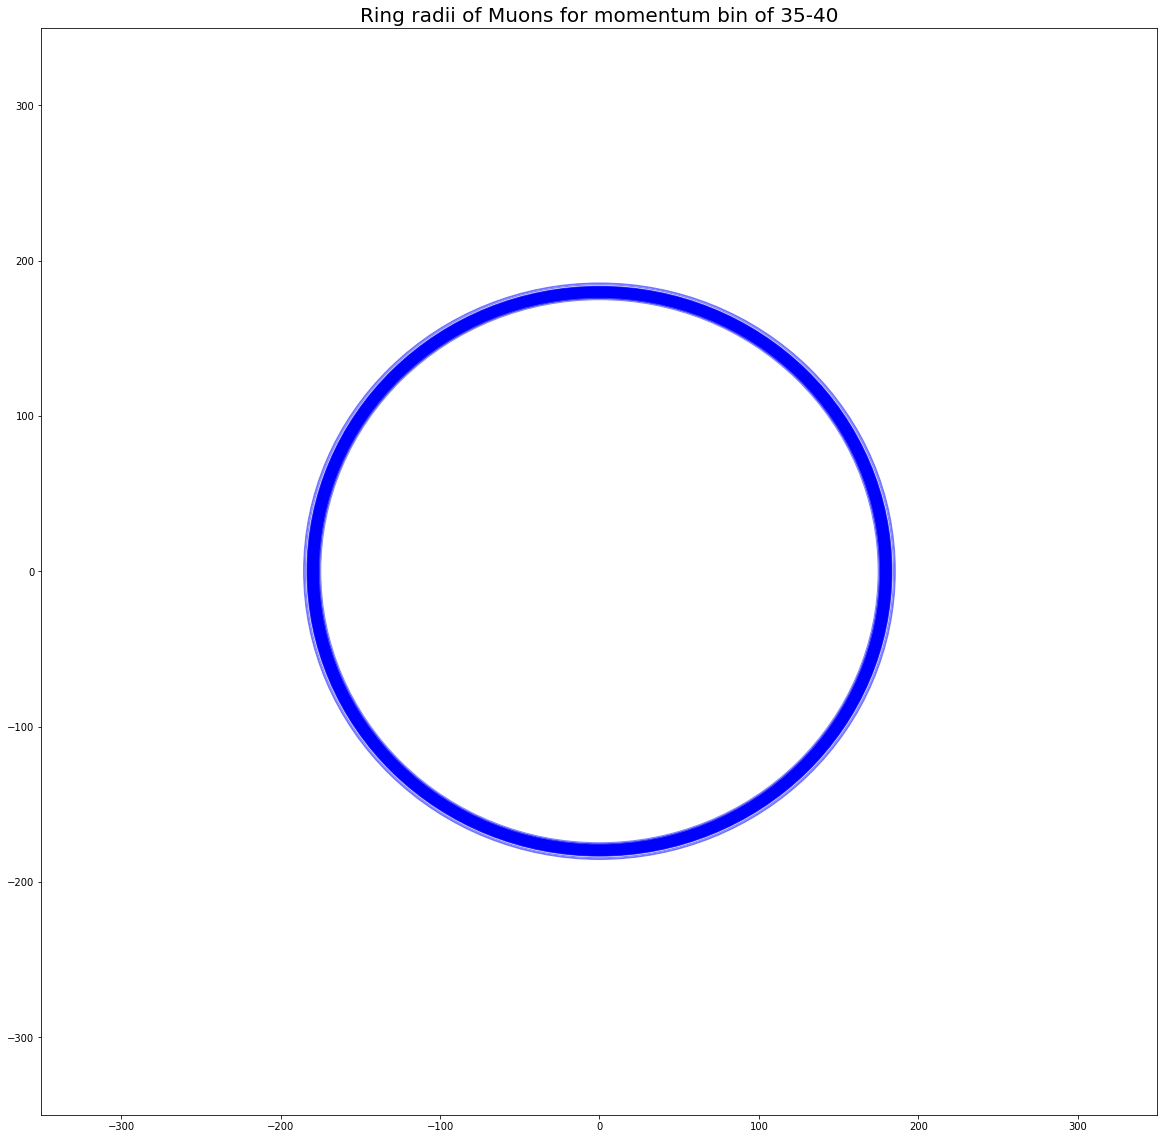

In [140]:
bins=[(10,15),(15,20),(20,25),(25,30),(30,35), (35,40)]

for bin_ in bins:

    muon, muon_event, pion, pion_event, positron, positron_event=hit_data_array(dfile, 1000, bin_[0], bin_[1], 1)
    fig,ax=plt.subplots(figsize=(20,20))
    plt.title(f"Ring radii of Muons for momentum bin of {bin_[0]}-{bin_[1]}", fontsize=20)
    ax.set_xlim(-350,350) # mm
    ax.set_ylim(-350,350) # mm

    for event in range(0,len(pion)):
        ax.add_artist(plt.Circle((0, 0), pion_event[event][2], fill=False, color='blue', alpha=0.5))

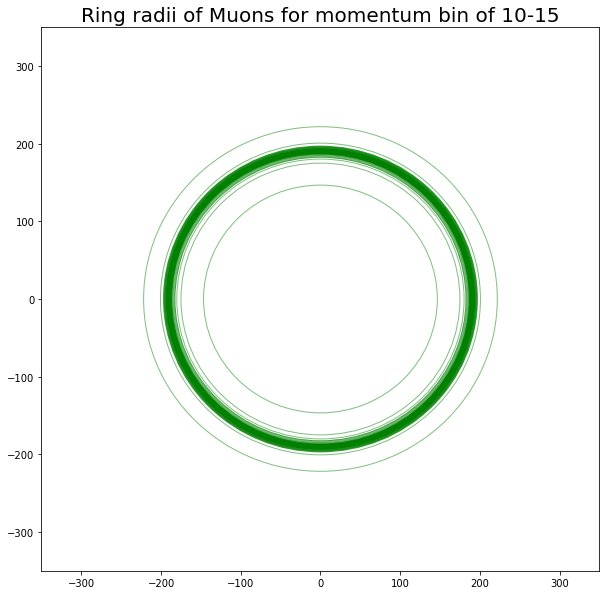

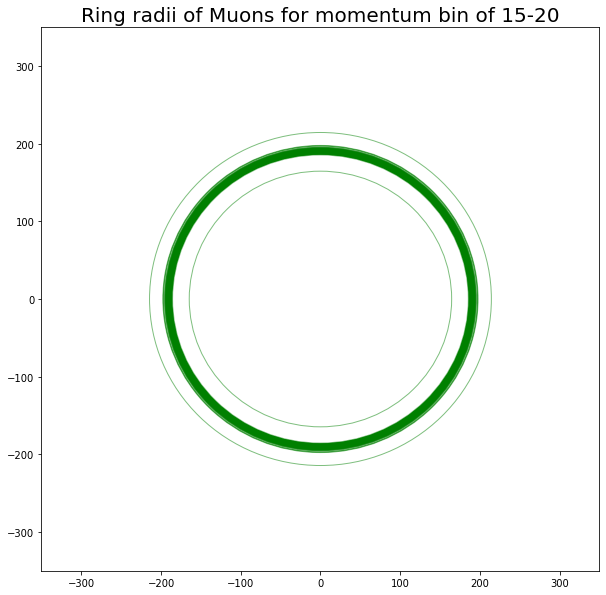

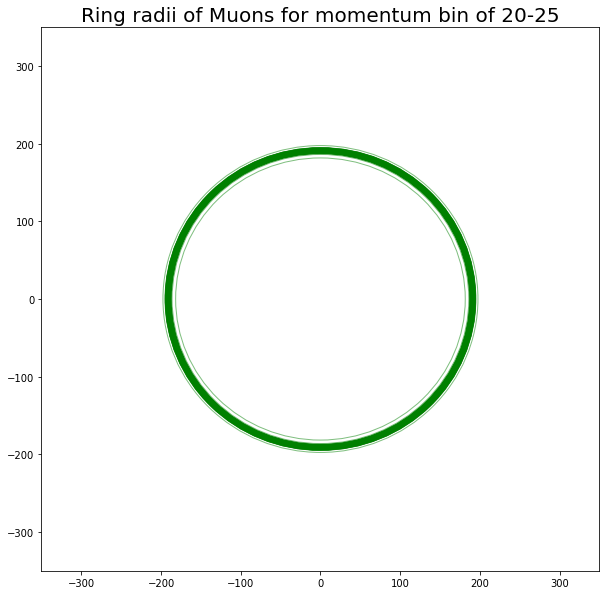

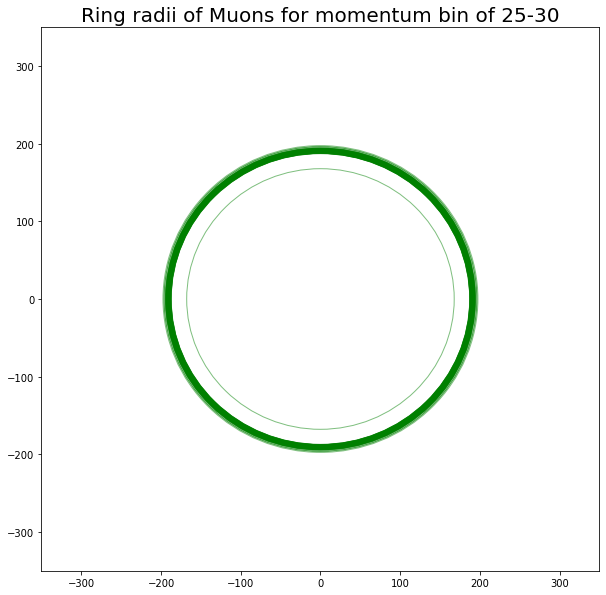

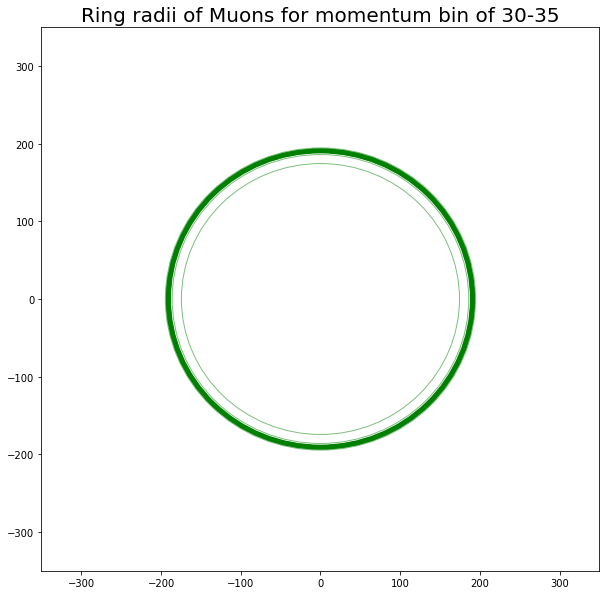

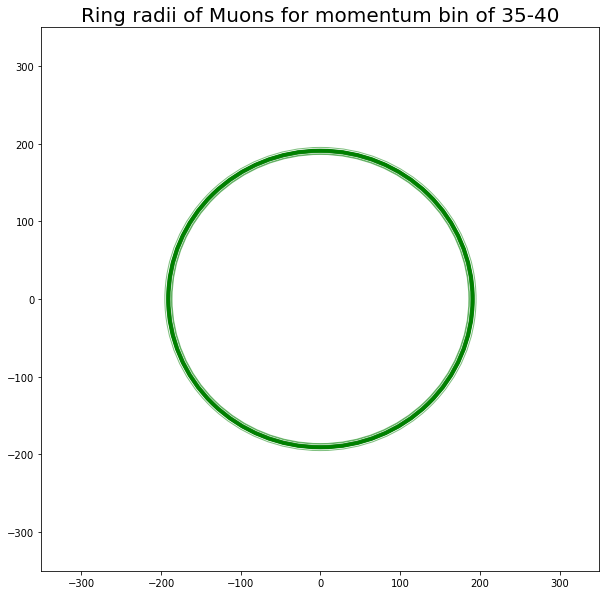

In [141]:
bins=[(10,15),(15,20),(20,25),(25,30),(30,35), (35,40)]

for bin_ in bins:

    muon, muon_event, pion, pion_event, positron, positron_event=hit_data_array(dfile, 1000, bin_[0], bin_[1], 1)
    fig,ax=plt.subplots(figsize=(10,10))
    plt.title(f"Ring radii of Muons for momentum bin of {bin_[0]}-{bin_[1]}", fontsize=20)
    ax.set_xlim(-350,350) # mm
    ax.set_ylim(-350,350) # mm
    
    for event in range(0,len(positron)):
        ax.add_artist(plt.Circle((0, 0), positron_event[event][2], fill=False, color='green', alpha=0.5))
        

# Ring radius by momentum (overlapping)

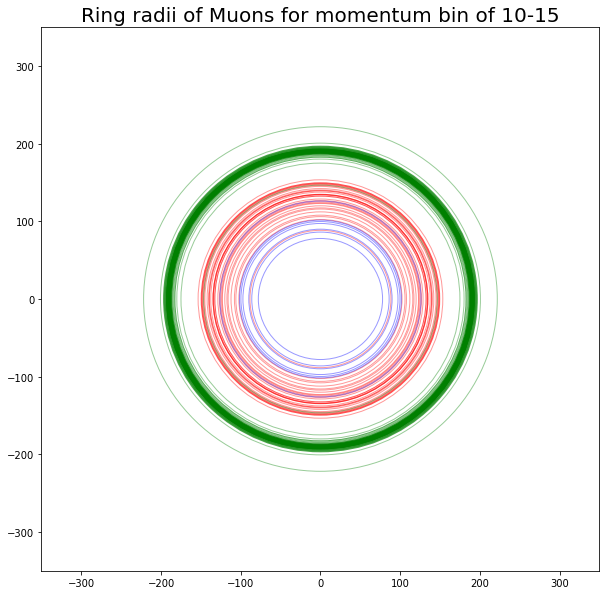

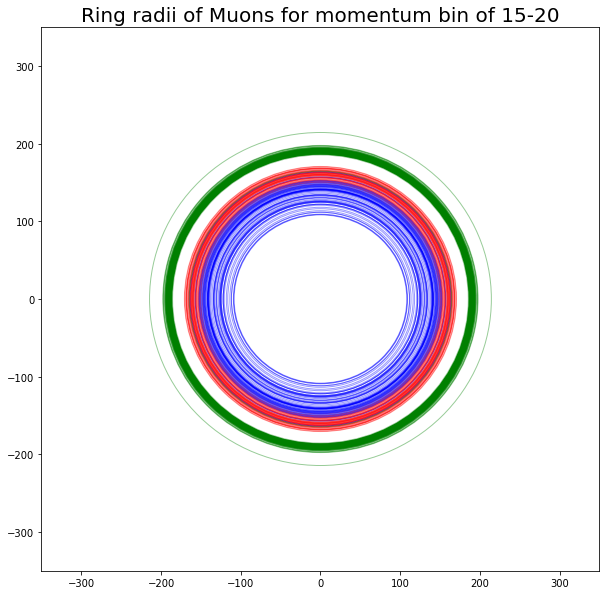

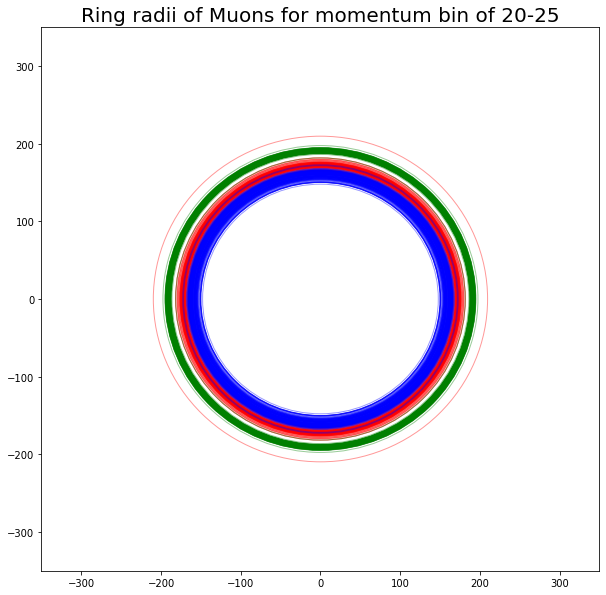

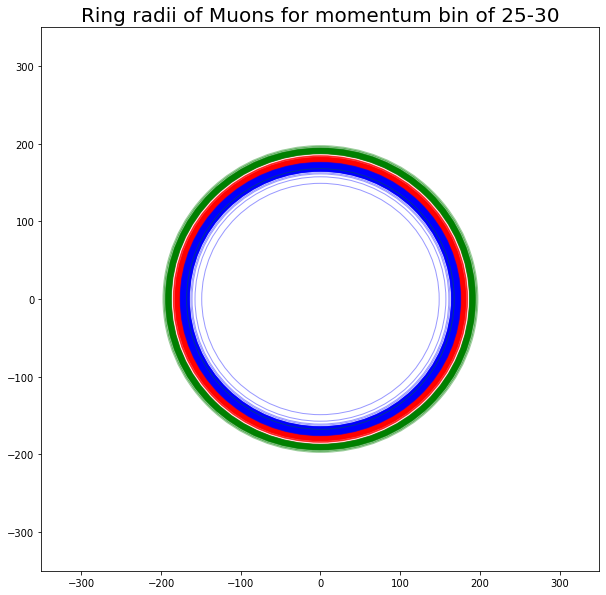

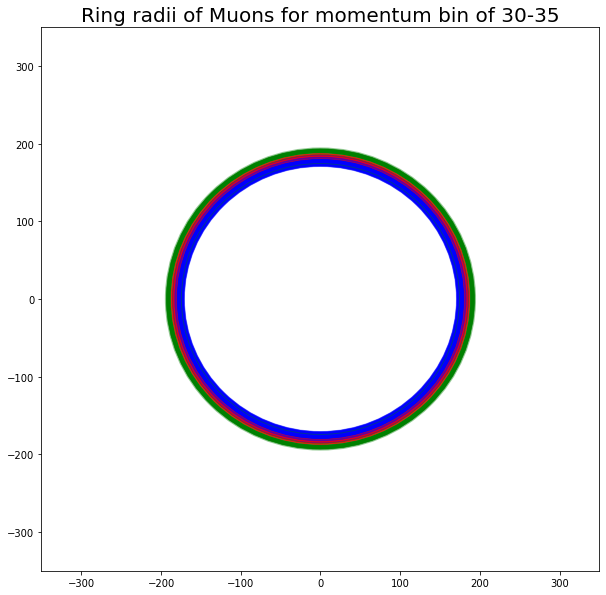

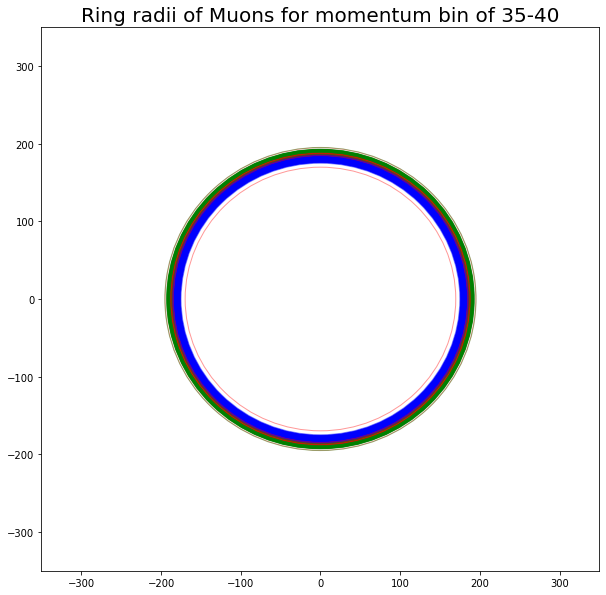

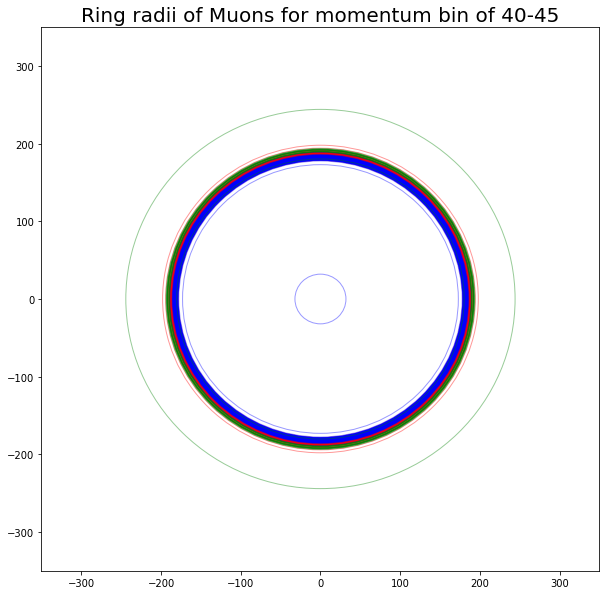

In [142]:
bins=[(10,15),(15,20),(20,25),(25,30),(30,35), (35,40), (40,45)]

for bin_ in bins:

    muon, muon_event, pion, pion_event, positron, positron_event=hit_data_array(dfile, 1000, bin_[0], bin_[1], 1)
    fig,ax=plt.subplots(figsize=(10,10))
    plt.title(f"Ring radii of Muons for momentum bin of {bin_[0]}-{bin_[1]}", fontsize=20)
    ax.set_xlim(-350,350) # mm
    ax.set_ylim(-350,350) # mm
    
    
    for event in range(0,len(muon)):
        ax.add_artist(plt.Circle((0, 0), muon_event[event][2], fill=False, color='red', alpha=0.4))
    
    for event in range(0,len(pion)):
        ax.add_artist(plt.Circle((0, 0), pion_event[event][2], fill=False, color='blue', alpha=0.4))

    for event in range(0,len(positron)):
        ax.add_artist(plt.Circle((0, 0), positron_event[event][2], fill=False, color='green', alpha=0.4))